<table class="ee-notebook-buttons" align="left">
    <td><a target="_blank"  href="https://github.com/NINAnor/urban-treeDetection"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" style="filter: invert(100%)"/> View source on GitHub</a></td>
    <td><a target="_blank"  href="https://drive.google.com/drive/folders/1mEQBfa-tVViVWFt27XzUP4Wr19u1iuZm"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a></td>
</table>

# Urban Tree Detection | Extrapolating Ecosystem Service Values

**Author:** Willeke A'Campo

**Description:** Script to clean the output i-Tree Eco dataset and extrapolate the Ecosystem Service Values to all trees in the municipality. The regression is trained on the in situ tree dataset from the municipality or if not availabe on Oslo's tree in situ tree data. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# import geopandas as gpd
from scipy import stats

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# import py-packages
import os
import logging

# import local packages
from src.config.config import load_catalog, load_parameters
from src.config import logger

# configure logger
logger.setup_logging()
logger = logging.getLogger(__name__)

# configure seaborn plot
sns.set_theme(
    context="notebook",  # paper, notebook, talk, and poster
    style="darkgrid",  # darkgrid, whitegrid, dark, white, and ticks
    palette="dark",  # deep, muted, bright, pastel, dark, and colorblind
    font="sans-serif",  # font family: serif, sans-serif, cursive, fantasy, and monospace
    font_scale=1,  # 1 = default font size (12pt)
    color_codes=True,  # False = don't color code from current palette
    rc=None,  # dict for additional settings (e.g. axes.labelsize=15)
)

2023-10-20 15:07:43 root [INFO]: Logging configuration file found and loaded.


In [4]:
# Load data and parameters
catalog = load_catalog()
parameters = load_parameters()
municipality = parameters["municipality"]
print(municipality)

# input
reference_excel = catalog["reference_oslo"]["filepath"]
reference_sheet = catalog["reference_oslo"]["sheet_names"][1]
target_excel = catalog["target_municipality"]["filepath"]
target_sheet = catalog["target_municipality"]["sheet_names"][1]
print(reference_sheet)
print(target_sheet)

# output
output_extrapolation = catalog["extrapolated_values"]["filepath"]
print(output_extrapolation)

baerum
reference_data
target_data
C:/Data/offline_data/trekroner/data/baerum/itree-support-tools/processed/baerum_extrapolated_values.csv


### Import Reference Data Oslo

In [5]:
# Load reference data 
workbook = pd.ExcelFile(reference_excel)
sheet_names = workbook.sheet_names
print(f"workbook sheet names: {sheet_names}")

df_raw = pd.read_excel(reference_excel, sheet_name=reference_sheet)

# import metadata
df_metadata = pd.read_excel(reference_excel, sheet_name="metadata")
df_metadata = df_metadata[["urban-treeDetection_colnames", "python_colnames", "dtype"]]

# import genus list
df_genus = pd.read_excel(reference_excel, sheet_name="unique_genus")
genus_bins = df_genus["genus"].tolist()

print("Raw data information: Oslo Reference Data")
display(df_raw.head())
print("Rows in dataframe: ", len(df_raw))
print(f"\nunique genus: {genus_bins}")
print("\nMetadata information: ")
display(df_metadata.head())

workbook sheet names: ['test_extrapolation_data', 'reference_data', 'unique_taxon', 'unique_genus', 'metadata']
Raw data information: Oslo Reference Data


,tree_id,crown_id,pollution_zone,crown_area_m2,tree_height_m,taxon_name,dbh_cm,crown_area_origin,total_tree_height_origin,taxon_origin,...,co_seq_kg,runoff_m3,polution_no2_g,polution_so2_g,polution_pm25_g,polution_co_g,polution_o3_g,totben_cap_nok,wgs84_lon,wgs84_lat
0,14689,4977.0,1.0,87.319154,15.081635,NaN,37.386005,"ALS, intersecting BYM, LiDAR",measured from DSM-DTM 3x3 rook's nb,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.657796,59.969877
1,14690,4978.0,1.0,105.000534,4.408203,NaN,13.635651,"ALS, intersecting BYM, LiDAR",measured from DSM-DTM point value,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.657938,59.969788
2,14691,NaN,1.0,NaN,1.832062,NaN,6.637312,NaN,measured from DSM-DTM 3x3 rook's nb,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.658075,59.969748
3,14692,NaN,1.0,NaN,3.208923,NaN,10.509838,NaN,measured from DSM-DTM 3x3 rook's nb,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.658295,59.969679
4,14693,17997.0,1.0,9.230826,0.679657,NaN,2.943466,"ALS, intersecting BYM, Thiessen",measured from DSM-DTM 3x3 rook's nb,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.657486,59.970029


Rows in dataframe:  29928

unique genus: ['Fraxinus', 'Acer', 'Ulmus', 'Betula', 'Picea', 'Pinus', 'Fagus', 'Tilia', 'Thuja', 'Salix', 'Populus', 'Alnus', 'Quercus', 'Malus', 'Prunus', 'Aesculus', 'Larix', 'Laburnum', 'Sorbus', 'Photinia', 'Cercidiphyllum', 'Pseudotsuga', 'Carpinus', 'Cupressocyparis', 'Juglans', 'Magnolia', 'Pyrus', 'Ginkgo', 'Crataegus', 'Syringa', 'Abies', 'Tsuga', 'Corylus', 'Pterocarya', 'Castanea', 'Metasequoia', 'Taxus', 'Liriodendron', 'Phellodendron', 'Ailanthus', 'Robinia', 'Davidia', 'Platanus', 'Juniperus']

Metadata information: 


,urban-treeDetection_colnames,python_colnames,dtype
0,tree_id,tree_id,int
1,crown_id,crown_id,int
2,pollution_zone,pollution_zone,int
3,crown_area_m2,crown_area,float64
4,tree_height_m,tree_height,float64


### Clean dataset
- remove rows with missing values
- remove rows with negative values (not done)

In [6]:
# drop rows with missing values
df = df_raw.dropna()
# drop rows with missing values
df = df.dropna()
display(df.head())

,tree_id,crown_id,pollution_zone,crown_area_m2,tree_height_m,taxon_name,dbh_cm,crown_area_origin,total_tree_height_origin,taxon_origin,...,co_seq_kg,runoff_m3,polution_no2_g,polution_so2_g,polution_pm25_g,polution_co_g,polution_o3_g,totben_cap_nok,wgs84_lon,wgs84_lat
73,14640,18010.0,1.0,7.644361,6.354904,Fraxinus,18.404785,"ALS, intersecting BYM, Thiessen",measured from DSM-DTM 3x3 rook's nb,1.0,...,3.0,0.1,8.2,0.6,0.9,0.7,18.3,671.685832,10.641744,59.961983
75,14644,4988.0,1.0,168.883335,15.855560,Acer,38.952046,"ALS, intersecting BYM, LiDAR",measured from DSM-DTM 3x3 rook's nb,1.0,...,15.1,3.7,234.5,17.3,24.5,21.2,525.4,15053.486424,10.642142,59.962042
76,14645,18012.0,1.0,126.770866,18.937744,Fraxinus,45.059931,"ALS, intersecting BYM, Thiessen",measured from DSM-DTM 3x3 rook's nb,1.0,...,10.6,1.6,99.3,7.3,10.4,9.0,222.4,7341.197038,10.642501,59.962011
78,14647,4987.0,1.0,221.395426,16.470413,Fraxinus,40.186395,"ALS, intersecting BYM, LiDAR",measured from DSM-DTM point value,1.0,...,12.9,2.1,132.5,9.8,13.8,12.0,296.9,9792.374558,10.643127,59.962118
79,14648,4985.0,1.0,124.750169,12.257553,Ulmus,31.540783,"ALS, intersecting BYM, LiDAR",measured from DSM-DTM 3x3 rook's nb,1.0,...,9.5,1.5,96.5,7.1,10.1,8.7,216.1,6663.597074,10.643412,59.962164


- rename columns 
- trim column names
- set dtype of columns 

In [7]:
# trim and rename columns using metadata
col_name_mapping = dict(
    zip(df_metadata["urban-treeDetection_colnames"], df_metadata["python_colnames"])
)
df.columns = df.columns.str.strip()
df.rename(columns=col_name_mapping, inplace=True)
df.columns = df.columns.str.strip()

# update column dtypes using metadata
dtype_mapping = dict(zip(df_metadata["python_colnames"], df_metadata["dtype"]))

# remove all values from dtype_mapping if they are not in df.columns
dtype_mapping = {
    key: dtype_mapping[key] for key in dtype_mapping.keys() if key in df.columns
}

# convert column dtypes using dtype_mapping
for key in dtype_mapping.keys():
    # print(f"column: {key}\t current dtype: {df[key].dtypes} \ttarget dtype: {dtype_mapping[key]}")
    # if the current dtype is not the target dtype, convert the column
    if df[key].dtypes != dtype_mapping[key]:
        try:
            if dtype_mapping[key] == "int":
                df[key] = df[key].astype(int)
                print(f"column: {key} converted to {df[key].dtypes}")
            elif dtype_mapping[key] == "float64":
                df[key] = df[key].astype(float)
                print(f"column: {key} converted to {df[key].dtypes}")
            elif dtype_mapping[key] == "object":
                df.astype({key: "object"}).dtypes
                print(f"column: {key} converted to {df[key].dtypes}")
        except ValueError:
            print(
                f"column: {key} ({df[key].dtypes}) could not be converted to {dtype_mapping[key]}"
            )
            pass
    else:
        print(
            f"column: {key} ({df[key].dtypes}) has already dtype: {dtype_mapping[key]}"
        )
        pass

column: tree_id converted to int32
column: crown_id converted to int32
column: pollution_zone converted to int32
column: crown_area (float64) has already dtype: float64
column: tree_height (float64) has already dtype: float64
column: genus (object) has already dtype: object
column: dbh (float64) has already dtype: float64
column: crown_area_origin (object) has already dtype: object
column: height_origin (object) has already dtype: object
column: sp_in_situ converted to int32
column: dbh_in_situ converted to int32
column: dbh_origin (object) has already dtype: object
column: carbon_storage (float64) has already dtype: float64
column: carbon_seq (float64) has already dtype: float64
column: runoff (float64) has already dtype: float64
column: polution_no2 (float64) has already dtype: float64
column: polution_so2 (float64) has already dtype: float64
column: polution_pm25 (float64) has already dtype: float64
column: polution_co (float64) has already dtype: float64
column: polution_o3 (float6

### Import and clean Target dataset (Baerum)

In [8]:
df_target_raw = pd.read_excel(target_excel, sheet_name=target_sheet)

In [9]:
display(df_target_raw.head())

,OBJECTID,crown_id,tree_id,norwegian_name,taxon_genus,common_name,species_origin,crown_area,height_total_tree,height_origin,dbh,dbh_origin,pollution_zone,nb_code,nb_name,geo_relation,wgs84_lon,wgs84_lat
0,1,b_302416_867,itree_1279,eik,Quercus,oak spp,feltregistrering,200.855927,20.180000,laserdata,81.169022,feltregistrering,1,302416,Slependen-Tanum,Case 1,10.461032,59.896740
1,2,b_302416_869,itree_1422,eik,Quercus,oak spp,feltregistrering,106.490250,20.910000,laserdata,NaN,NaN,1,302416,Slependen-Tanum,Case 1,10.456046,59.894114
2,3,b_302416_877,itree_1310,eik,Quercus,oak spp,feltregistrering,109.864700,20.400000,laserdata,87.535217,feltregistrering,1,302416,Slependen-Tanum,Case 1,10.464117,59.892444
3,4,b_302416_878,itree_1301,eik,Quercus,oak spp,feltregistrering,24.497925,19.010000,laserdata,181.436630,feltregistrering,1,302416,Slependen-Tanum,Case 1,10.464022,59.892115
4,5,b_302416_880,itree_1322,eik,Quercus,oak spp,feltregistrering,48.870377,17.209999,laserdata,66.845078,feltregistrering,1,302416,Slependen-Tanum,Case 1,10.466653,59.891559


In [10]:
# drop row with missing values in column "crown_area", "height_total_tree" or "pollution_zone"
df_target= df_target_raw.dropna(subset=["crown_area", "height_total_tree", "pollution_zone"])
print("Length of Complete DF:", len(df_target_raw))
print ("Length of Cleaned DF:", len(df_target))

Length of Complete DF: 219439
Length of Cleaned DF: 218564


In [11]:
col_list = df.columns
print(col_list)

# drop columns that are in the target dataset
col_list = [col for col in col_list if col not in df_target.columns]
print(col_list)

# add col list as columns to target_df
df_target = pd.concat([df_target, pd.DataFrame(columns=col_list)], axis=1)
df_target["tree_height"] = df_target["height_total_tree"]
df_target["genus"] = df_target["taxon_genus"]
df_target["lon_x"] = df_target["wgs84_lon"]
df_target["lat_y"] = df_target["wgs84_lat"]
display(df_target.head())

Index(['tree_id', 'crown_id', 'pollution_zone', 'crown_area', 'tree_height',
       'genus', 'dbh', 'crown_area_origin', 'height_origin', 'sp_in_situ',
       'dbh_in_situ', 'dbh_origin', 'carbon_storage', 'carbon_seq', 'runoff',
       'polution_no2', 'polution_so2', 'polution_pm25', 'polution_co',
       'polution_o3', 'totben_cap', 'lon_x', 'lat_y'],
      dtype='object')
['tree_height', 'genus', 'crown_area_origin', 'sp_in_situ', 'dbh_in_situ', 'carbon_storage', 'carbon_seq', 'runoff', 'polution_no2', 'polution_so2', 'polution_pm25', 'polution_co', 'polution_o3', 'totben_cap', 'lon_x', 'lat_y']


,OBJECTID,crown_id,tree_id,norwegian_name,taxon_genus,common_name,species_origin,crown_area,height_total_tree,height_origin,...,carbon_seq,runoff,polution_no2,polution_so2,polution_pm25,polution_co,polution_o3,totben_cap,lon_x,lat_y
0,1,b_302416_867,itree_1279,eik,Quercus,oak spp,feltregistrering,200.855927,20.180000,laserdata,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.461032,59.896740
1,2,b_302416_869,itree_1422,eik,Quercus,oak spp,feltregistrering,106.490250,20.910000,laserdata,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.456046,59.894114
2,3,b_302416_877,itree_1310,eik,Quercus,oak spp,feltregistrering,109.864700,20.400000,laserdata,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.464117,59.892444
3,4,b_302416_878,itree_1301,eik,Quercus,oak spp,feltregistrering,24.497925,19.010000,laserdata,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.464022,59.892115
4,5,b_302416_880,itree_1322,eik,Quercus,oak spp,feltregistrering,48.870377,17.209999,laserdata,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.466653,59.891559


In [12]:
df_target.columns = df_target.columns.str.strip()

# remove all values from dtype_mapping if they are not in df.columns
dtype_mapping = {
    key: dtype_mapping[key] for key in dtype_mapping.keys() if key in df_target.columns
}

# convert column dtypes using dtype_mapping
for key in dtype_mapping.keys():
    # print(f"column: {key}\t current dtype: {df[key].dtypes} \ttarget dtype: {dtype_mapping[key]}")
    # if the current dtype is not the target dtype, convert the column
    if df_target[key].dtypes != dtype_mapping[key]:
        try:
            if dtype_mapping[key] == "int":
                df_target[key] = df_target[key].astype(int)
                print(f"column: {key} converted to {df_target[key].dtypes}")
            elif dtype_mapping[key] == "float64":
                df_target[key] = df_target[key].astype(float)
                print(f"column: {key} converted to {df_target[key].dtypes}")
            elif dtype_mapping[key] == "object":
                df_target.astype({key: "object"}).dtypes
                print(f"column: {key} converted to {df_target[key].dtypes}")
        except ValueError:
            print(
                f"column: {key} ({df_target[key].dtypes}) could not be converted to {dtype_mapping[key]}"
            )
            pass
    else:
        print(
            f"column: {key} ({df_target[key].dtypes}) has already dtype: {dtype_mapping[key]}"
        )
        pass

column: tree_id (object) could not be converted to int
column: crown_id (object) could not be converted to int
column: pollution_zone converted to int32
column: crown_area (float64) has already dtype: float64
column: tree_height (float64) has already dtype: float64
column: genus (object) has already dtype: object
column: dbh (float64) has already dtype: float64
column: crown_area_origin (object) has already dtype: object
column: height_origin (object) has already dtype: object
column: sp_in_situ (object) could not be converted to int
column: dbh_in_situ (object) could not be converted to int
column: dbh_origin (object) has already dtype: object
column: carbon_storage converted to float64
column: carbon_seq converted to float64
column: runoff converted to float64
column: polution_no2 converted to float64
column: polution_so2 converted to float64
column: polution_pm25 converted to float64
column: polution_co converted to float64
column: polution_o3 converted to float64
column: totben_cap

### Correlation analysis 

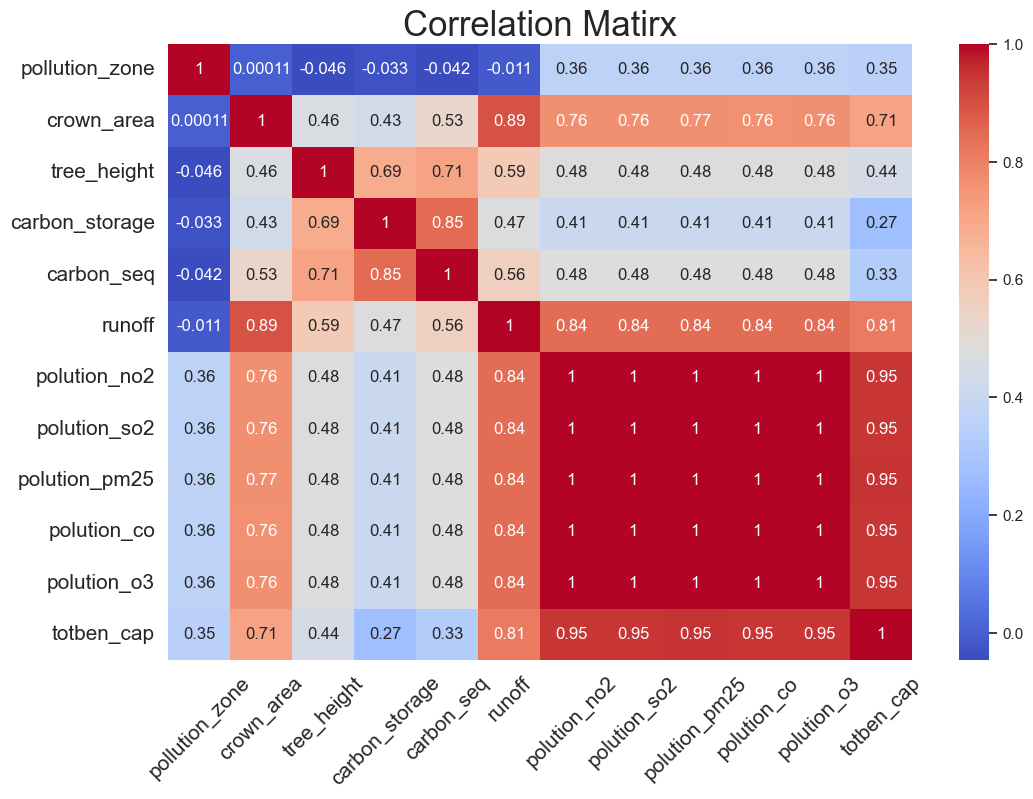

In [13]:
# drop columns with name 'id' and 'genus'
df_corr = df.drop(
    ["tree_id", "crown_id", "dbh", "dbh_in_situ", "sp_in_situ", "lon_x", "lat_y"], axis=1
)
correlation_matrix = df_corr.corr()

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
ax.set_title("Correlation Matirx", fontweight="ultralight", fontsize=25)
plt.xticks(rotation=45, fontweight="ultralight", fontsize=15)
plt.yticks(fontsize=15)
plt.show()

- select columns to keep for modelling
- round values for pred and response var to 3 decimals (ensure that X,Y columns are not rounded!)

In [14]:
# print(df.columns)
col_id = ["tree_id", "crown_id"]
col_coord = ["lon_x", "lat_y"]
predictors = ["tree_height", "crown_area", "pollution_zone", "genus"]
response_vars = [
    "carbon_storage",
    "carbon_seq",
    "runoff",
    "polution_no2",
    "polution_so2",
    "polution_pm25",
    "polution_co",
    "polution_o3",
    "totben_cap",
]

col_to_keep = col_id + predictors + response_vars + col_coord
print(col_to_keep)
df = df[col_to_keep]

# round response and predictor values to 2 decimals
df[predictors + response_vars] = df[predictors + response_vars].round(2)
print("REFERENCE DATA:")
display(df.head())


df_target = df_target[col_to_keep]
df_target[predictors + response_vars] = df_target[predictors + response_vars].round(2)
print("TARGET DATA:")
display(df_target.head())

['tree_id', 'crown_id', 'tree_height', 'crown_area', 'pollution_zone', 'genus', 'carbon_storage', 'carbon_seq', 'runoff', 'polution_no2', 'polution_so2', 'polution_pm25', 'polution_co', 'polution_o3', 'totben_cap', 'lon_x', 'lat_y']
REFERENCE DATA:


,tree_id,crown_id,tree_height,crown_area,pollution_zone,genus,carbon_storage,carbon_seq,runoff,polution_no2,polution_so2,polution_pm25,polution_co,polution_o3,totben_cap,lon_x,lat_y
73,14640,18010,6.35,7.64,1,Fraxinus,61.0,3.0,0.1,8.2,0.6,0.9,0.7,18.3,671.69,10.641744,59.961983
75,14644,4988,15.86,168.88,1,Acer,372.8,15.1,3.7,234.5,17.3,24.5,21.2,525.4,15053.49,10.642142,59.962042
76,14645,18012,18.94,126.77,1,Fraxinus,537.0,10.6,1.6,99.3,7.3,10.4,9.0,222.4,7341.20,10.642501,59.962011
78,14647,4987,16.47,221.40,1,Fraxinus,324.8,12.9,2.1,132.5,9.8,13.8,12.0,296.9,9792.37,10.643127,59.962118
79,14648,4985,12.26,124.75,1,Ulmus,174.4,9.5,1.5,96.5,7.1,10.1,8.7,216.1,6663.60,10.643412,59.962164


TARGET DATA:


,tree_id,crown_id,tree_height,crown_area,pollution_zone,genus,carbon_storage,carbon_seq,runoff,polution_no2,polution_so2,polution_pm25,polution_co,polution_o3,totben_cap,lon_x,lat_y
0,itree_1279,b_302416_867,20.18,200.86,1,Quercus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.461032,59.896740
1,itree_1422,b_302416_869,20.91,106.49,1,Quercus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.456046,59.894114
2,itree_1310,b_302416_877,20.40,109.86,1,Quercus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.464117,59.892444
3,itree_1301,b_302416_878,19.01,24.50,1,Quercus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.464022,59.892115
4,itree_1322,b_302416_880,17.21,48.87,1,Quercus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.466653,59.891559


In [15]:
# create a histogram for genus distribution
df_genus = df.groupby("genus").count()
df_genus = df_genus[["tree_id"]]
df_genus.rename(columns={"tree_id": "count"}, inplace=True)
df_genus.sort_values(by=["count"], inplace=True, ascending=False)
df_genus.reset_index(inplace=True)

# probability distribution of genus in percent
df_genus["probability"] = df_genus["count"] / df_genus["count"].sum()
df_genus["prob_percentage"] = round(df_genus["probability"] * 100)
display(df_genus.head())

df_genus["probability"].sum()

,genus,count,probability,prob_percentage
0,Tilia,4152,0.259825,26.0
1,Acer,3242,0.202879,20.0
2,Betula,1909,0.119462,12.0
3,Ulmus,1249,0.078160,8.0
4,Prunus,1044,0.065332,7.0


0.9999999999999999

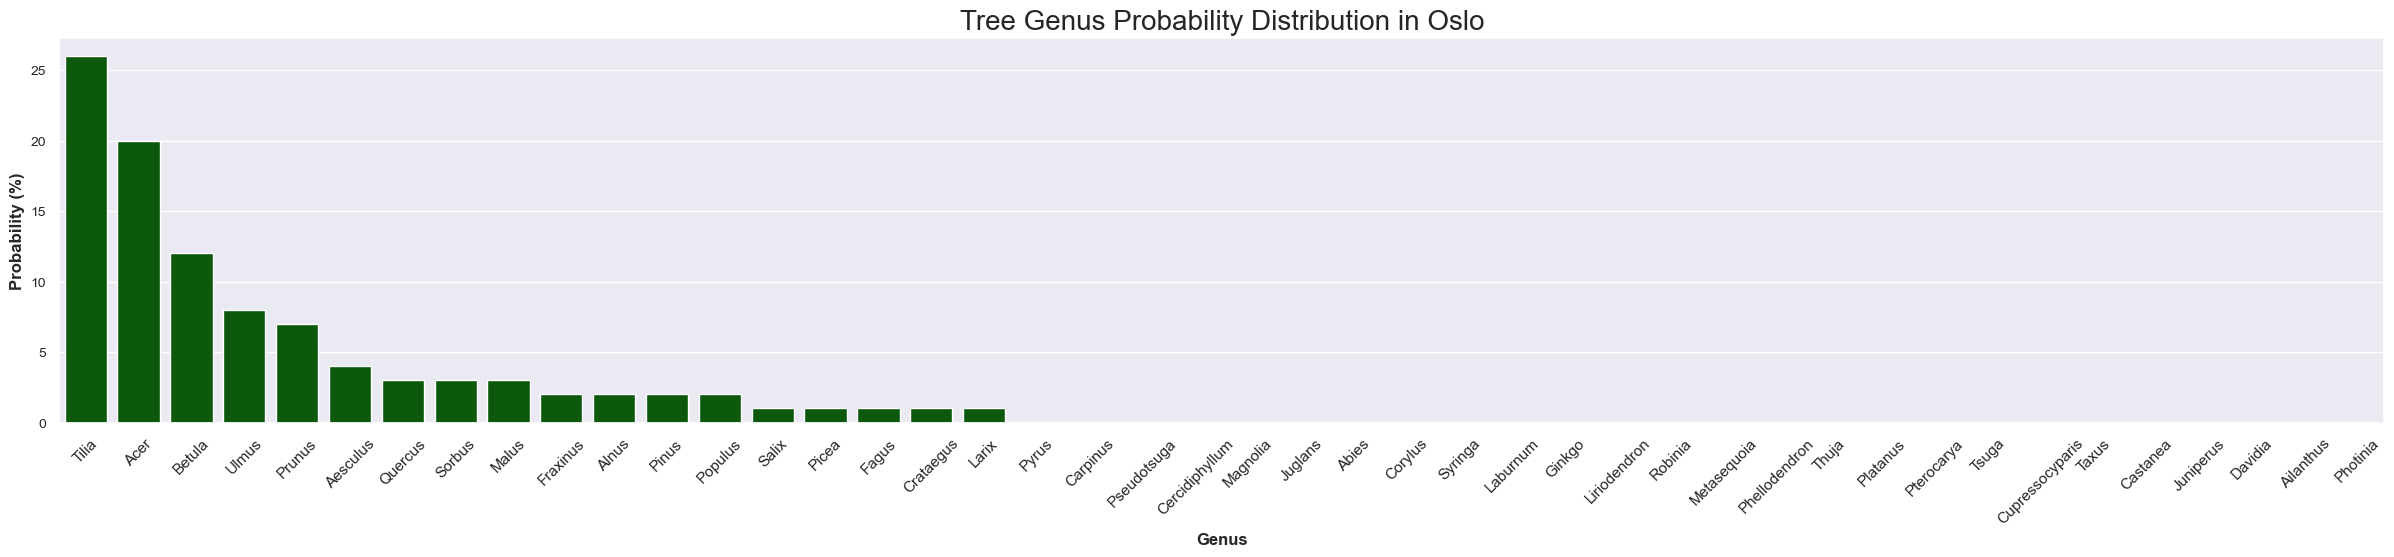

In [16]:
# plot histogram
fig, ax = plt.subplots(figsize=(30, 5))
sns.barplot(x="genus", y="prob_percentage", data=df_genus, ax=ax, color="darkgreen")
ax.set_title(
    "Tree Genus Probability Distribution in Oslo", fontweight="ultralight", fontsize=20
)
ax.set_xlabel("Genus", fontweight="bold")
ax.set_ylabel("Probability (%)", fontweight="bold")
plt.xticks(rotation=45, fontweight="ultralight")
plt.yticks(fontsize=10)
plt.show()

### Fill Target Dataset with Genus values using the probability distribution of Oslo 

In [17]:
# fil no data values in test_df['genus'] by using the probability distribution of df['genus']
df_target["genus"] = df_target["genus"].apply(
    lambda x: np.random.choice(df_genus["genus"], p=df_genus["probability"])
    if pd.isnull(x)
    else x
)

# print the probability distribution of target_data['genus']
target_data_genus = df_target.groupby("genus").count()
target_data_genus = target_data_genus[["tree_id"]]
target_data_genus.rename(columns={"tree_id": "count"}, inplace=True)
target_data_genus.sort_values(by=["count"], inplace=True, ascending=False)
target_data_genus.reset_index(inplace=True)

,genus,count,probability,prob_percentage
0,Acer,143,0.265799,27.0
1,Quercus,137,0.254647,25.0
2,Fraxinus,93,0.172862,17.0
3,Tilia,39,0.072491,7.0
4,Ulmus,38,0.070632,7.0


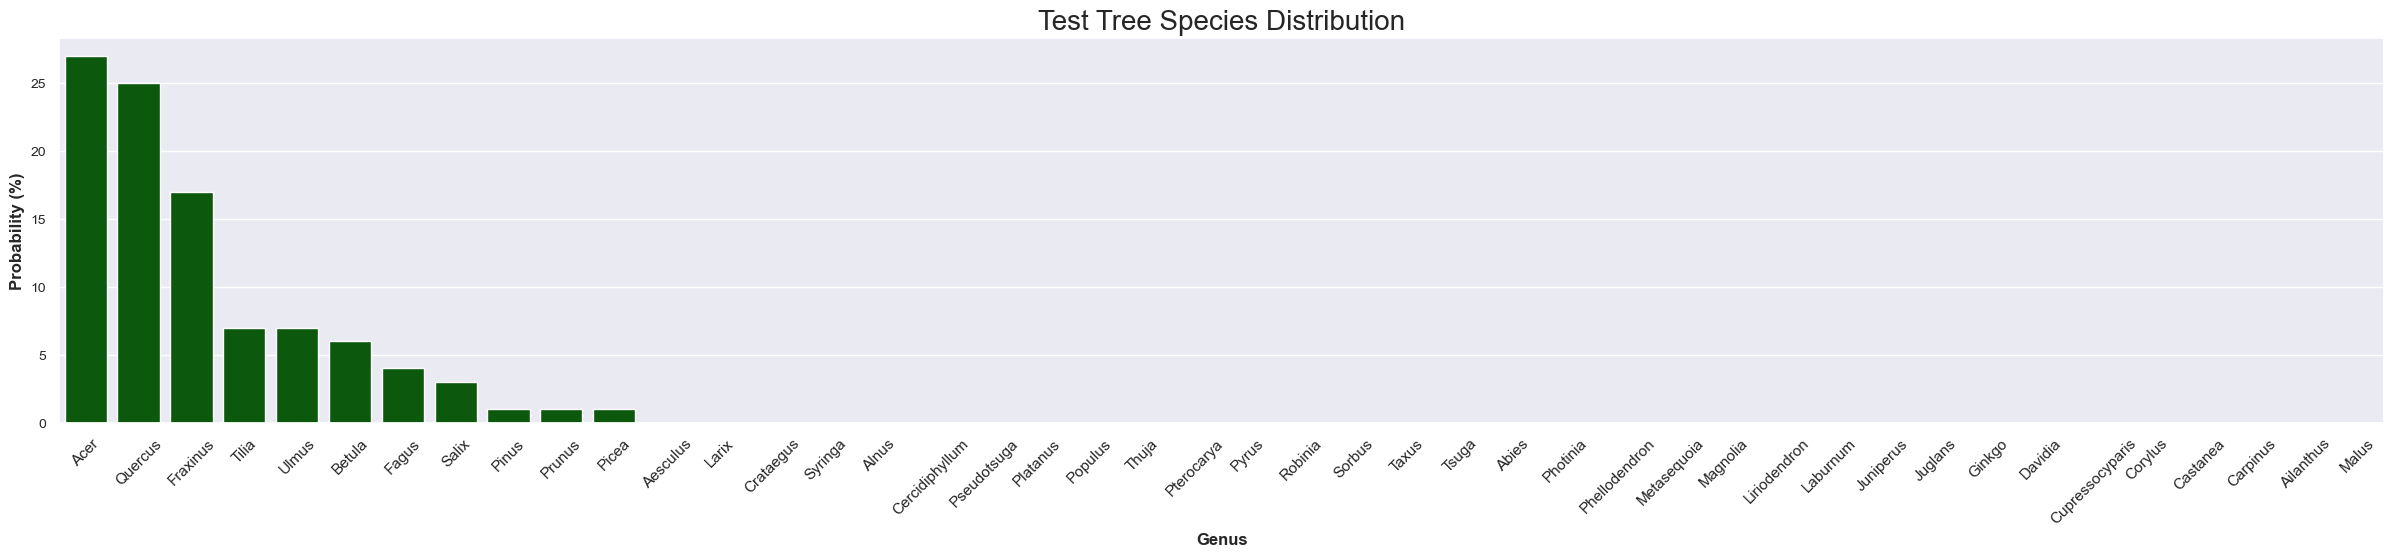

In [18]:
# probability distribution of genus in percent
target_data_genus["probability"] = (
    target_data_genus["count"] / target_data_genus["count"].sum()
)
target_data_genus["prob_percentage"] = round(target_data_genus["probability"] * 100)
display(target_data_genus.head())

# plot histogram
fig, ax = plt.subplots(figsize=(30, 5))
sns.barplot(
    x="genus", y="prob_percentage", data=target_data_genus, ax=ax, color="darkgreen"
)
ax.set_title("Test Tree Species Distribution", fontweight="ultralight", fontsize=20)
ax.set_xlabel("Genus", fontweight="bold")
ax.set_ylabel("Probability (%)", fontweight="bold")
plt.xticks(rotation=45, fontweight="ultralight")
plt.yticks(fontsize=10)
plt.show()

In [19]:
display(df_target.head())

,tree_id,crown_id,tree_height,crown_area,pollution_zone,genus,carbon_storage,carbon_seq,runoff,polution_no2,polution_so2,polution_pm25,polution_co,polution_o3,totben_cap,lon_x,lat_y
0,itree_1279,b_302416_867,20.18,200.86,1,Quercus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.461032,59.896740
1,itree_1422,b_302416_869,20.91,106.49,1,Quercus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.456046,59.894114
2,itree_1310,b_302416_877,20.40,109.86,1,Quercus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.464117,59.892444
3,itree_1301,b_302416_878,19.01,24.50,1,Quercus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.464022,59.892115
4,itree_1322,b_302416_880,17.21,48.87,1,Quercus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.466653,59.891559


### Non-weighted Regression with encoded genus info

In [20]:
# One-hot encoding for species
df["genus"] = df["genus"].astype("category")

# encode genus for regression
genus_encoded = pd.get_dummies(df["genus"], prefix="genus")

# get genus encoded column names
genus_encoded_cols = list(genus_encoded.columns)
# replace genus_ wiht "" in column names
genus_encoded_cols = [x.replace("genus_", "") for x in genus_encoded_cols]
genus_encoded_cols = [x.lower() for x in genus_encoded_cols]

# replace col names with formatted col names
genus_encoded.columns = genus_encoded_cols

df = pd.concat([df, genus_encoded], axis=1)
print(genus_encoded_cols)

['abies', 'acer', 'aesculus', 'ailanthus', 'alnus', 'betula', 'carpinus', 'castanea', 'cercidiphyllum', 'corylus', 'crataegus', 'cupressocyparis', 'davidia', 'fagus', 'fraxinus', 'ginkgo', 'juglans', 'juniperus', 'laburnum', 'larix', 'liriodendron', 'magnolia', 'malus', 'metasequoia', 'phellodendron', 'photinia', 'picea', 'pinus', 'platanus', 'populus', 'prunus', 'pseudotsuga', 'pterocarya', 'pyrus', 'quercus', 'robinia', 'salix', 'sorbus', 'syringa', 'taxus', 'thuja', 'tilia', 'tsuga', 'ulmus']


In [21]:
target_genus_encoded = pd.get_dummies(df_target["genus"])
target_genus_encoded_cols = list(target_genus_encoded.columns)
target_genus_encoded_cols = [x.lower() for x in target_genus_encoded_cols]

# replace col names with formatted col names
target_genus_encoded.columns = target_genus_encoded_cols

df_target = pd.concat([df_target, target_genus_encoded], axis=1)
display(df_target.head())

,tree_id,crown_id,tree_height,crown_area,pollution_zone,genus,carbon_storage,carbon_seq,runoff,polution_no2,...,quercus,robinia,salix,sorbus,syringa,taxus,thuja,tilia,tsuga,ulmus
0,itree_1279,b_302416_867,20.18,200.86,1,Quercus,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
1,itree_1422,b_302416_869,20.91,106.49,1,Quercus,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
2,itree_1310,b_302416_877,20.40,109.86,1,Quercus,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
3,itree_1301,b_302416_878,19.01,24.50,1,Quercus,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
4,itree_1322,b_302416_880,17.21,48.87,1,Quercus,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0


In [22]:
# ensure that df and df_target contain the same column names
same_columns = df.columns.equals(df_target.columns)
print(same_columns)
print(df.columns)
print(df_target.columns)

True
Index(['tree_id', 'crown_id', 'tree_height', 'crown_area', 'pollution_zone',
       'genus', 'carbon_storage', 'carbon_seq', 'runoff', 'polution_no2',
       'polution_so2', 'polution_pm25', 'polution_co', 'polution_o3',
       'totben_cap', 'lon_x', 'lat_y', 'abies', 'acer', 'aesculus',
       'ailanthus', 'alnus', 'betula', 'carpinus', 'castanea',
       'cercidiphyllum', 'corylus', 'crataegus', 'cupressocyparis', 'davidia',
       'fagus', 'fraxinus', 'ginkgo', 'juglans', 'juniperus', 'laburnum',
       'larix', 'liriodendron', 'magnolia', 'malus', 'metasequoia',
       'phellodendron', 'photinia', 'picea', 'pinus', 'platanus', 'populus',
       'prunus', 'pseudotsuga', 'pterocarya', 'pyrus', 'quercus', 'robinia',
       'salix', 'sorbus', 'syringa', 'taxus', 'thuja', 'tilia', 'tsuga',
       'ulmus'],
      dtype='object')
Index(['tree_id', 'crown_id', 'tree_height', 'crown_area', 'pollution_zone',
       'genus', 'carbon_storage', 'carbon_seq', 'runoff', 'polution_no2',
     

In [23]:
# Extract the features (X) and the target variable (y) from the DataFrame
predictors = ["tree_height", "crown_area", "pollution_zone"] + genus_encoded_cols
response_vars = [
    "carbon_storage",
    "carbon_seq",
    "runoff",
    "polution_no2",
    "polution_so2",
    "polution_pm25",
    "polution_co",
    "polution_o3",
    "totben_cap",
]

for var in response_vars:
    y = df[var]

Model: carbon_storage
Equation: y = -214.7 + 37.7*tree_height + 0.6*crown_area + 6.0*pollution_zone + -51.5*abies + ...


,tree_id,crown_id,tree_height,crown_area,pollution_zone,genus,carbon_storage,carbon_seq,runoff,polution_no2,...,quercus,robinia,salix,sorbus,syringa,taxus,thuja,tilia,tsuga,ulmus
0,itree_1279,b_302416_867,20.18,200.86,1,Quercus,750.664149,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
1,itree_1422,b_302416_869,20.91,106.49,1,Quercus,720.531587,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
2,itree_1310,b_302416_877,20.40,109.86,1,Quercus,703.344173,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
3,itree_1301,b_302416_878,19.01,24.50,1,Quercus,598.710534,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
4,itree_1322,b_302416_880,17.21,48.87,1,Quercus,545.674816,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0


<Figure size 640x480 with 0 Axes>

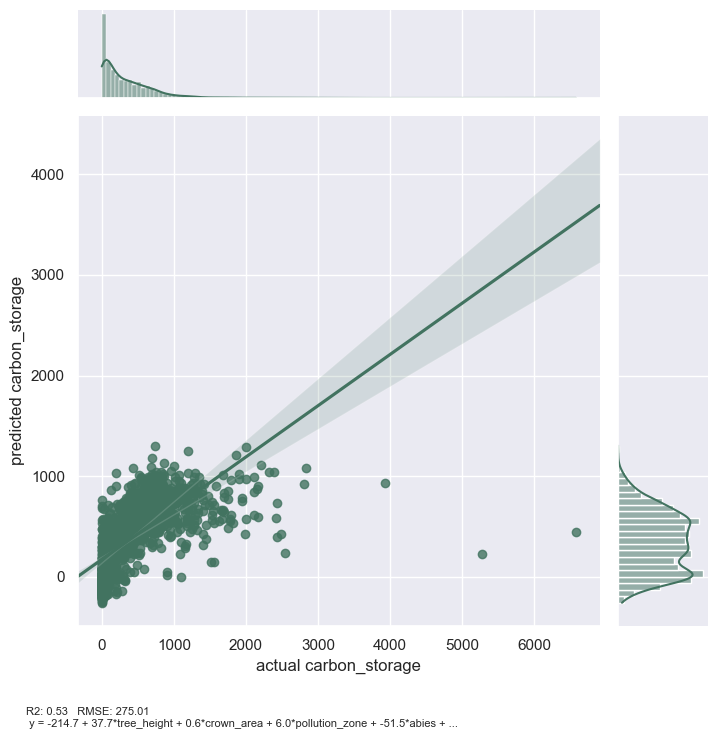

Model: carbon_seq
Equation: y = -1.1 + 0.5*tree_height + 0.0*crown_area + 0.0*pollution_zone + -1.6*abies + ...


,tree_id,crown_id,tree_height,crown_area,pollution_zone,genus,carbon_storage,carbon_seq,runoff,polution_no2,...,quercus,robinia,salix,sorbus,syringa,taxus,thuja,tilia,tsuga,ulmus
0,itree_1279,b_302416_867,20.18,200.86,1,Quercus,750.664149,15.553388,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
1,itree_1422,b_302416_869,20.91,106.49,1,Quercus,720.531587,14.136822,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
2,itree_1310,b_302416_877,20.40,109.86,1,Quercus,703.344173,13.934561,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
3,itree_1301,b_302416_878,19.01,24.50,1,Quercus,598.710534,11.581991,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
4,itree_1322,b_302416_880,17.21,48.87,1,Quercus,545.674816,11.105827,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0


<Figure size 640x480 with 0 Axes>

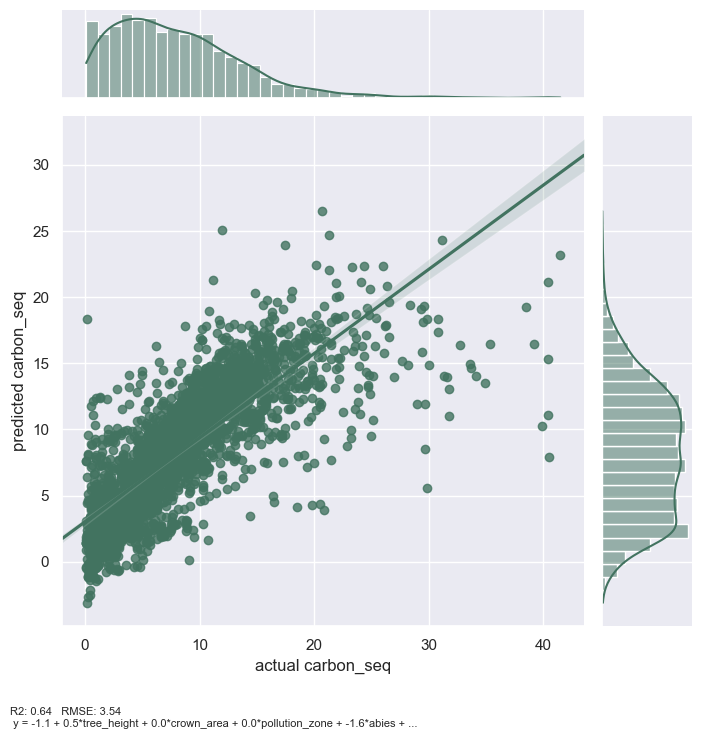

Model: runoff
Equation: y = -0.2 + 0.0*tree_height + 0.0*crown_area + -0.0*pollution_zone + 0.2*abies + ...


,tree_id,crown_id,tree_height,crown_area,pollution_zone,genus,carbon_storage,carbon_seq,runoff,polution_no2,...,quercus,robinia,salix,sorbus,syringa,taxus,thuja,tilia,tsuga,ulmus
0,itree_1279,b_302416_867,20.18,200.86,1,Quercus,750.664149,15.553388,3.010758,NaN,...,1,0,0,0,0,0,0,0,0,0
1,itree_1422,b_302416_869,20.91,106.49,1,Quercus,720.531587,14.136822,1.746550,NaN,...,1,0,0,0,0,0,0,0,0,0
2,itree_1310,b_302416_877,20.40,109.86,1,Quercus,703.344173,13.934561,1.772779,NaN,...,1,0,0,0,0,0,0,0,0,0
3,itree_1301,b_302416_878,19.01,24.50,1,Quercus,598.710534,11.581991,0.549129,NaN,...,1,0,0,0,0,0,0,0,0,0
4,itree_1322,b_302416_880,17.21,48.87,1,Quercus,545.674816,11.105827,0.812606,NaN,...,1,0,0,0,0,0,0,0,0,0


<Figure size 640x480 with 0 Axes>

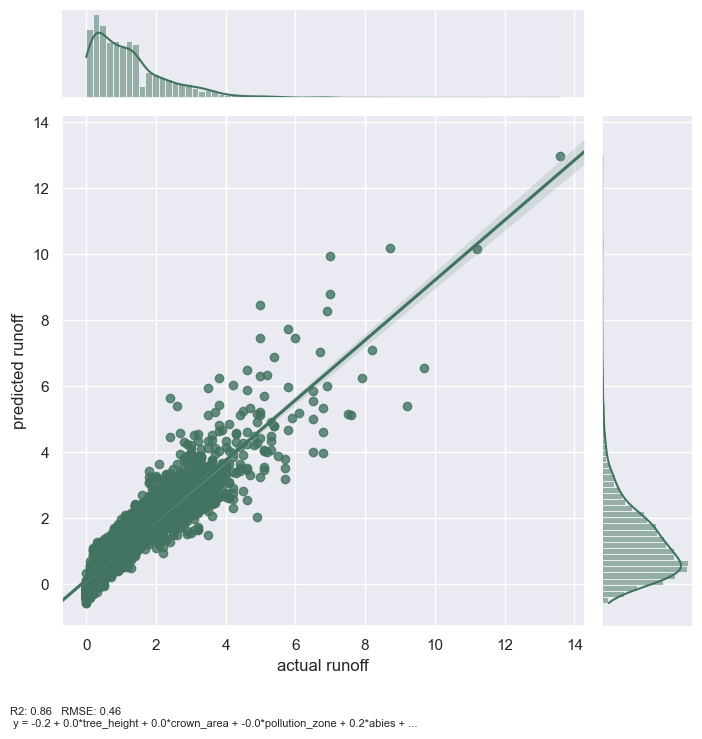

Model: polution_no2
Equation: y = -330.5 + 7.2*tree_height + 2.4*crown_area + 168.1*pollution_zone + 14.8*abies + ...


,tree_id,crown_id,tree_height,crown_area,pollution_zone,genus,carbon_storage,carbon_seq,runoff,polution_no2,...,quercus,robinia,salix,sorbus,syringa,taxus,thuja,tilia,tsuga,ulmus
0,itree_1279,b_302416_867,20.18,200.86,1,Quercus,750.664149,15.553388,3.010758,387.765749,...,1,0,0,0,0,0,0,0,0,0
1,itree_1422,b_302416_869,20.91,106.49,1,Quercus,720.531587,14.136822,1.746550,164.232262,...,1,0,0,0,0,0,0,0,0,0
2,itree_1310,b_302416_877,20.40,109.86,1,Quercus,703.344173,13.934561,1.772779,168.728442,...,1,0,0,0,0,0,0,0,0,0
3,itree_1301,b_302416_878,19.01,24.50,1,Quercus,598.710534,11.581991,0.549129,-48.233813,...,1,0,0,0,0,0,0,0,0,0
4,itree_1322,b_302416_880,17.21,48.87,1,Quercus,545.674816,11.105827,0.812606,-2.118162,...,1,0,0,0,0,0,0,0,0,0


<Figure size 640x480 with 0 Axes>

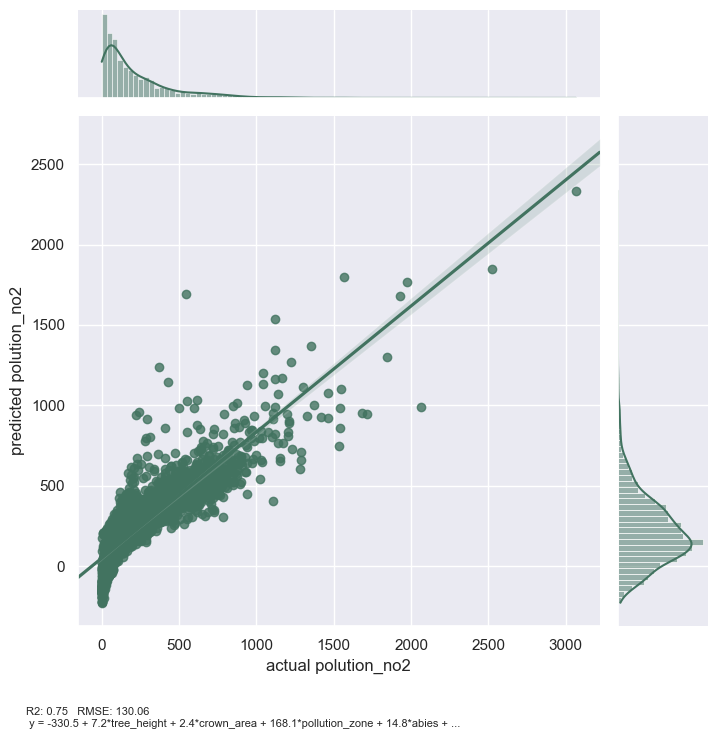

Model: polution_so2
Equation: y = -24.4 + 0.5*tree_height + 0.2*crown_area + 12.4*pollution_zone + 1.1*abies + ...


,tree_id,crown_id,tree_height,crown_area,pollution_zone,genus,carbon_storage,carbon_seq,runoff,polution_no2,...,quercus,robinia,salix,sorbus,syringa,taxus,thuja,tilia,tsuga,ulmus
0,itree_1279,b_302416_867,20.18,200.86,1,Quercus,750.664149,15.553388,3.010758,387.765749,...,1,0,0,0,0,0,0,0,0,0
1,itree_1422,b_302416_869,20.91,106.49,1,Quercus,720.531587,14.136822,1.746550,164.232262,...,1,0,0,0,0,0,0,0,0,0
2,itree_1310,b_302416_877,20.40,109.86,1,Quercus,703.344173,13.934561,1.772779,168.728442,...,1,0,0,0,0,0,0,0,0,0
3,itree_1301,b_302416_878,19.01,24.50,1,Quercus,598.710534,11.581991,0.549129,-48.233813,...,1,0,0,0,0,0,0,0,0,0
4,itree_1322,b_302416_880,17.21,48.87,1,Quercus,545.674816,11.105827,0.812606,-2.118162,...,1,0,0,0,0,0,0,0,0,0


<Figure size 640x480 with 0 Axes>

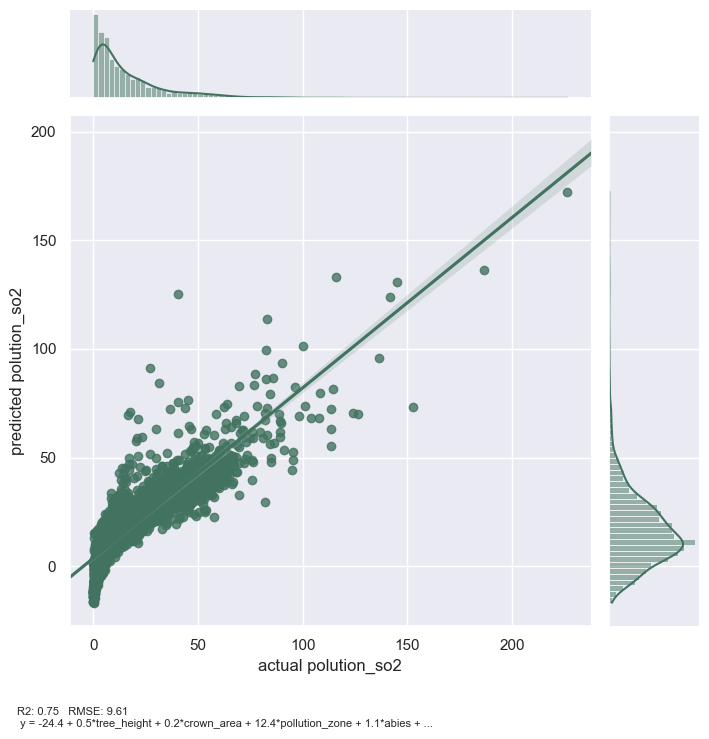

Model: polution_pm25
Equation: y = -33.7 + 0.7*tree_height + 0.2*crown_area + 17.2*pollution_zone + 1.7*abies + ...


,tree_id,crown_id,tree_height,crown_area,pollution_zone,genus,carbon_storage,carbon_seq,runoff,polution_no2,...,quercus,robinia,salix,sorbus,syringa,taxus,thuja,tilia,tsuga,ulmus
0,itree_1279,b_302416_867,20.18,200.86,1,Quercus,750.664149,15.553388,3.010758,387.765749,...,1,0,0,0,0,0,0,0,0,0
1,itree_1422,b_302416_869,20.91,106.49,1,Quercus,720.531587,14.136822,1.746550,164.232262,...,1,0,0,0,0,0,0,0,0,0
2,itree_1310,b_302416_877,20.40,109.86,1,Quercus,703.344173,13.934561,1.772779,168.728442,...,1,0,0,0,0,0,0,0,0,0
3,itree_1301,b_302416_878,19.01,24.50,1,Quercus,598.710534,11.581991,0.549129,-48.233813,...,1,0,0,0,0,0,0,0,0,0
4,itree_1322,b_302416_880,17.21,48.87,1,Quercus,545.674816,11.105827,0.812606,-2.118162,...,1,0,0,0,0,0,0,0,0,0


<Figure size 640x480 with 0 Axes>

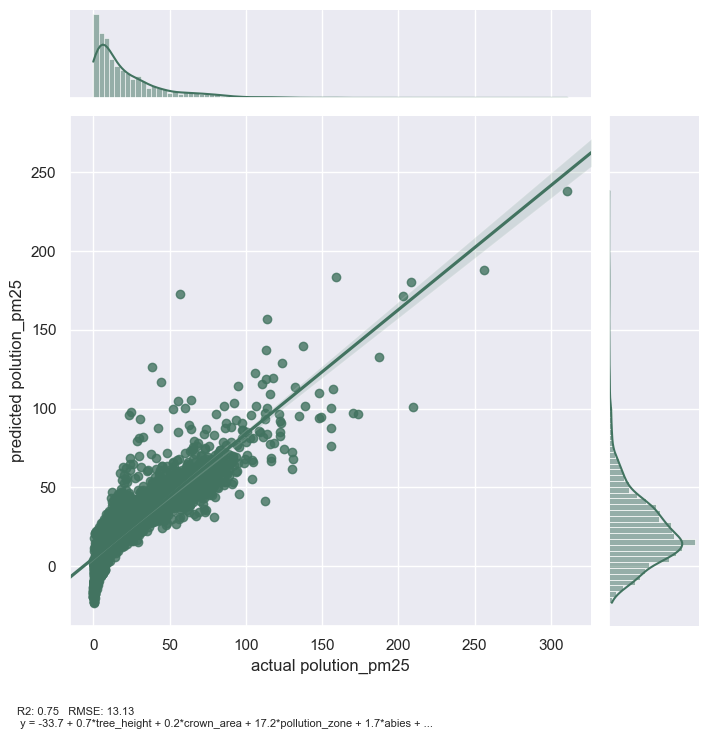

Model: polution_co
Equation: y = -30.6 + 0.7*tree_height + 0.2*crown_area + 15.6*pollution_zone + 1.3*abies + ...


,tree_id,crown_id,tree_height,crown_area,pollution_zone,genus,carbon_storage,carbon_seq,runoff,polution_no2,...,quercus,robinia,salix,sorbus,syringa,taxus,thuja,tilia,tsuga,ulmus
0,itree_1279,b_302416_867,20.18,200.86,1,Quercus,750.664149,15.553388,3.010758,387.765749,...,1,0,0,0,0,0,0,0,0,0
1,itree_1422,b_302416_869,20.91,106.49,1,Quercus,720.531587,14.136822,1.746550,164.232262,...,1,0,0,0,0,0,0,0,0,0
2,itree_1310,b_302416_877,20.40,109.86,1,Quercus,703.344173,13.934561,1.772779,168.728442,...,1,0,0,0,0,0,0,0,0,0
3,itree_1301,b_302416_878,19.01,24.50,1,Quercus,598.710534,11.581991,0.549129,-48.233813,...,1,0,0,0,0,0,0,0,0,0
4,itree_1322,b_302416_880,17.21,48.87,1,Quercus,545.674816,11.105827,0.812606,-2.118162,...,1,0,0,0,0,0,0,0,0,0


<Figure size 640x480 with 0 Axes>

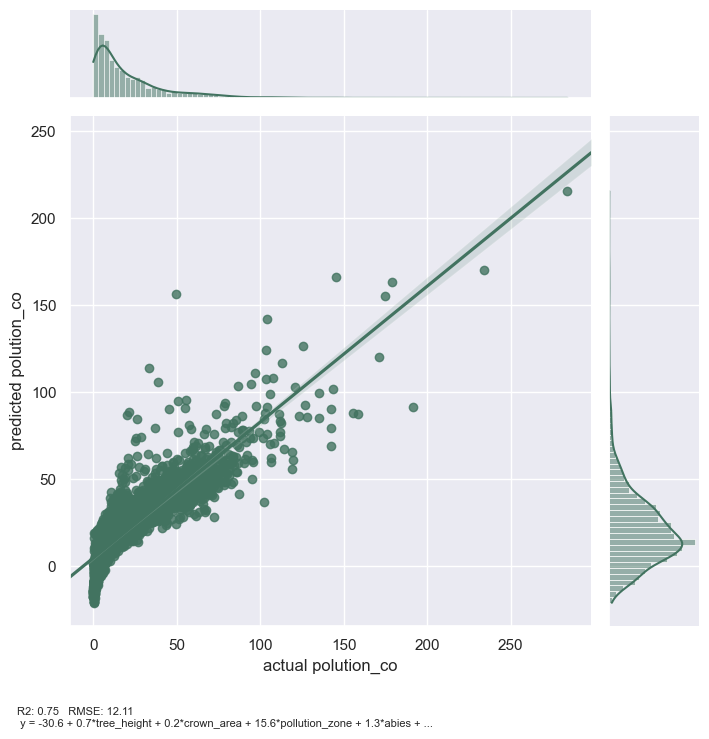

Model: polution_o3
Equation: y = -747.6 + 16.2*tree_height + 5.5*crown_area + 380.4*pollution_zone + 33.2*abies + ...


,tree_id,crown_id,tree_height,crown_area,pollution_zone,genus,carbon_storage,carbon_seq,runoff,polution_no2,...,quercus,robinia,salix,sorbus,syringa,taxus,thuja,tilia,tsuga,ulmus
0,itree_1279,b_302416_867,20.18,200.86,1,Quercus,750.664149,15.553388,3.010758,387.765749,...,1,0,0,0,0,0,0,0,0,0
1,itree_1422,b_302416_869,20.91,106.49,1,Quercus,720.531587,14.136822,1.746550,164.232262,...,1,0,0,0,0,0,0,0,0,0
2,itree_1310,b_302416_877,20.40,109.86,1,Quercus,703.344173,13.934561,1.772779,168.728442,...,1,0,0,0,0,0,0,0,0,0
3,itree_1301,b_302416_878,19.01,24.50,1,Quercus,598.710534,11.581991,0.549129,-48.233813,...,1,0,0,0,0,0,0,0,0,0
4,itree_1322,b_302416_880,17.21,48.87,1,Quercus,545.674816,11.105827,0.812606,-2.118162,...,1,0,0,0,0,0,0,0,0,0


<Figure size 640x480 with 0 Axes>

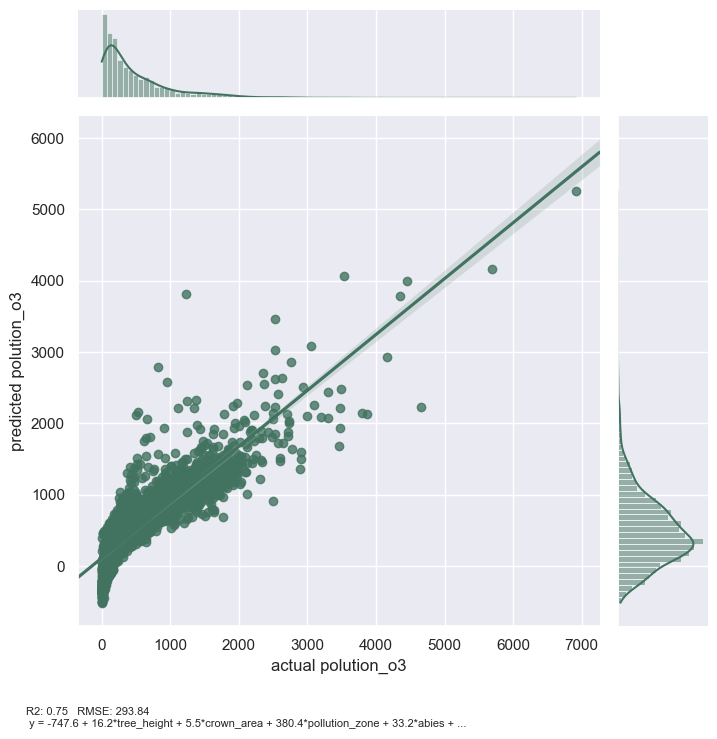

Model: totben_cap
Equation: y = -15422.8 + 328.5*tree_height + 124.1*crown_area + 8576.8*pollution_zone + 312.7*abies + ...


,tree_id,crown_id,tree_height,crown_area,pollution_zone,genus,carbon_storage,carbon_seq,runoff,polution_no2,...,quercus,robinia,salix,sorbus,syringa,taxus,thuja,tilia,tsuga,ulmus
0,itree_1279,b_302416_867,20.18,200.86,1,Quercus,750.664149,15.553388,3.010758,387.765749,...,1,0,0,0,0,0,0,0,0,0
1,itree_1422,b_302416_869,20.91,106.49,1,Quercus,720.531587,14.136822,1.746550,164.232262,...,1,0,0,0,0,0,0,0,0,0
2,itree_1310,b_302416_877,20.40,109.86,1,Quercus,703.344173,13.934561,1.772779,168.728442,...,1,0,0,0,0,0,0,0,0,0
3,itree_1301,b_302416_878,19.01,24.50,1,Quercus,598.710534,11.581991,0.549129,-48.233813,...,1,0,0,0,0,0,0,0,0,0
4,itree_1322,b_302416_880,17.21,48.87,1,Quercus,545.674816,11.105827,0.812606,-2.118162,...,1,0,0,0,0,0,0,0,0,0


<Figure size 640x480 with 0 Axes>

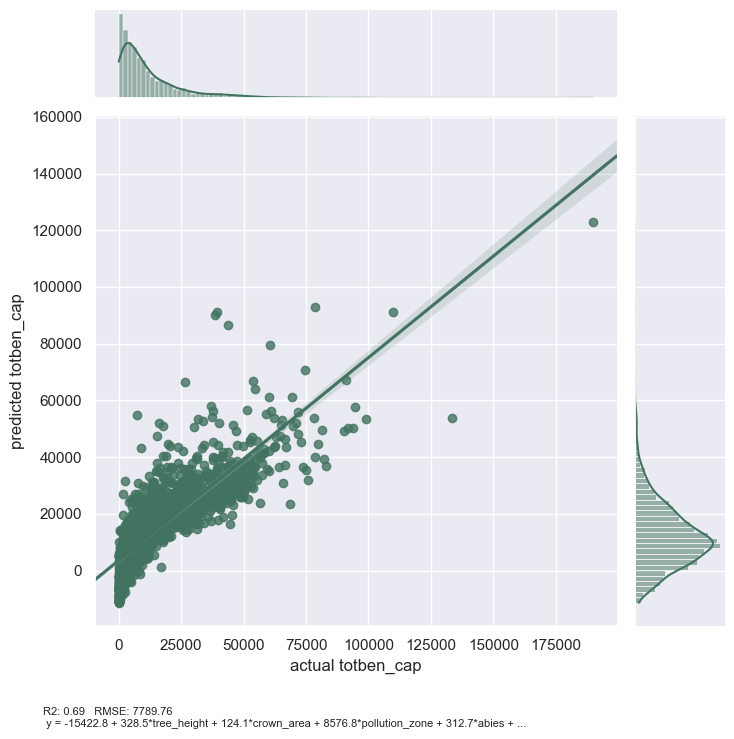

In [24]:
X = df[predictors]
X_target = df_target[predictors]
seed = 42
test_size = 0.2

dict_results = {}

# TODO store model in dictionairy {model_name:model}
# TODO store model results in dataframe df_results dict. {model_name:df_results}

# loop over response variables and calc. linear regression
for var in response_vars:
    y = df[var]

    # SPLIT DATA
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed
    )

    # TRAIN MODEL
    # Create and fit the regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    b0 = round(model.intercept_, 1)
    b1 = round(model.coef_[0], 1)
    b2 = round(model.coef_[1], 1)
    b3 = round(model.coef_[2], 1)
    b4 = round(model.coef_[3], 1)
    y = var
    x1 = predictors[0]
    x2 = predictors[1]
    x3 = predictors[2]
    x4 = predictors[3]

    model_equation = f"y = {b0} + {b1}*{x1} + {b2}*{x2} + {b3}*{x3} + {b4}*{x4} + ..."

    # Make predictions on the training and testing sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # EVALUATE MODEL
    # store model results in dataframe df_results
    r2_train = round(r2_score(y_train, y_train_pred), 2)
    r2_test = round(r2_score(y_test, y_test_pred), 2)
    r2_train = round(r2_train, 2)
    rmse_train = round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2)

    df_results = pd.DataFrame(
        columns=[
            "model_name",
            "response_var",
            "equation",
            "train_rmse",
            "test_rmse",
            "train_r2",
            "test_r2",
        ]
    )
    df_results["model_name"] = f"model_{var}"
    df_results["response_var"] = var
    df_results["equation"] = model_equation
    df_results["train_rmse"] = rmse_train
    df_results["test_rmse"] = np.sqrt(mean_squared_error(y_test, y_test_pred))
    df_results["train_r2"] = r2_train
    df_results["test_r2"] = r2_test

    # append results dataframe to dict
    dict_results[f"model_{var}"] = df_results

    # DEPLOY MODEL
    # Apply the regression model to the df_target dataset
    y_target_pred = model.predict(X_target)

    # Fill the response columns in df_target with the predicted values
    df_target[var] = y_target_pred

    # DISPLAY RESULTS
    print(f"Model: {var}")
    print(f"Equation: {model_equation}")
    display(df_target.head())

    # plot results and save plot to output folder
    plt.clf()  # clear figure

    # Regression plot
    sns.jointplot(
        x=y_test,
        y=y_test_pred,
        kind="reg",
        truncate=False,
        # xlim=(0, 60), ylim=(0, 12),
        color="#427360",
        height=7,
    )
    plt.xlabel(f"actual {var}")
    plt.ylabel(f"predicted {var}")
    plt.figtext(
        0,
        -0.05,
        f"R2: {r2_train}   RMSE: {rmse_train}\n {model_equation}",
        ha="left",
        fontsize=8,
    )
    plt.show()

    # save plot to output folder
    # output_path = os.path.join(INTERIM_PATH, f'linear_reg_{var}.png')
    # plt.savefig(output_path, dpi=300, bbox_inches='tight')

### Export Results

In [25]:
display(df_target.head())

# round values
df_target[predictors + response_vars] = round(df_target[predictors + response_vars], 3)

# drop genus cols
drop_cols = target_genus_encoded.columns


df_target.drop(drop_cols, axis=1, inplace=True)
display(df_target.head())

,tree_id,crown_id,tree_height,crown_area,pollution_zone,genus,carbon_storage,carbon_seq,runoff,polution_no2,...,quercus,robinia,salix,sorbus,syringa,taxus,thuja,tilia,tsuga,ulmus
0,itree_1279,b_302416_867,20.18,200.86,1,Quercus,750.664149,15.553388,3.010758,387.765749,...,1,0,0,0,0,0,0,0,0,0
1,itree_1422,b_302416_869,20.91,106.49,1,Quercus,720.531587,14.136822,1.746550,164.232262,...,1,0,0,0,0,0,0,0,0,0
2,itree_1310,b_302416_877,20.40,109.86,1,Quercus,703.344173,13.934561,1.772779,168.728442,...,1,0,0,0,0,0,0,0,0,0
3,itree_1301,b_302416_878,19.01,24.50,1,Quercus,598.710534,11.581991,0.549129,-48.233813,...,1,0,0,0,0,0,0,0,0,0
4,itree_1322,b_302416_880,17.21,48.87,1,Quercus,545.674816,11.105827,0.812606,-2.118162,...,1,0,0,0,0,0,0,0,0,0


,tree_id,crown_id,tree_height,crown_area,pollution_zone,genus,carbon_storage,carbon_seq,runoff,polution_no2,polution_so2,polution_pm25,polution_co,polution_o3,totben_cap,lon_x,lat_y
0,itree_1279,b_302416_867,20.18,200.86,1,Quercus,750.664,15.553,3.011,387.766,28.659,39.533,35.737,873.026,21607.908,10.461032,59.896740
1,itree_1422,b_302416_869,20.91,106.49,1,Quercus,720.532,14.137,1.747,164.232,12.146,16.749,15.099,369.064,10136.887,10.456046,59.894114
2,itree_1310,b_302416_877,20.40,109.86,1,Quercus,703.344,13.935,1.773,168.728,12.478,17.207,15.515,379.200,10387.530,10.464117,59.892444
3,itree_1301,b_302416_878,19.01,24.50,1,Quercus,598.711,11.582,0.549,-48.234,-3.549,-4.911,-4.514,-109.953,-661.906,10.464022,59.892115
4,itree_1322,b_302416_880,17.21,48.87,1,Quercus,545.675,11.106,0.813,-2.118,-0.142,-0.213,-0.255,-5.989,1770.915,10.466653,59.891559


In [26]:
# export the results in df_target
df_target.to_csv(output_extrapolation, index=False, sep=",")